In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from collections import Counter

## Pre-processing

This function reads from file and performs pre-precessing steps

In [23]:
def read_from_file(scenario):
    print("Reading from file. Scenario: %s" % scenario)

    # Get the path of the file
    dir_path = os.path.join("..", "data", "CTU-13-Dataset", str(scenario))
    file_name = filter(lambda x: x.endswith(".binetflow"), os.listdir(dir_path))[0]
    file_path = os.path.join(dir_path, file_name)

    # Read the csv file in a pandas dataframe
    # Convert label: "flow=From-Botnet" to 1, label: "flow=From-Normal" to 0 and the rest to 2
    converters = {"Label": lambda x: 1 if x.startswith("flow=From-Botnet") else (0 if x.startswith("flow=From-Normal") else 2)}
    df = pd.read_csv(file_path, skip_blank_lines=True, delimiter=",", converters=converters)

    # remove the background flows
    df = df[df.Label != 2]

    # Remove the columns which will not be used the clustering
    # sTos, dTos (Nan and 0 values)
    df.drop(["sTos", "dTos", "State", "DstAddr", "Sport", "Dport"], 1, inplace=True)

    print("\tDone!!")
    return df

This function reads from file for each of the given scenarios and converts it to one pandas dataframe

In [24]:
def read_scenarios(scenarios):
    result = []
    for scenario in scenarios:
        result.append(read_from_file(scenario))
    df = pd.concat(result)

    # Create dummy types
    df = pd.get_dummies(df, columns=["Proto", "Dir"])

    # Drop rows that contain null values for at-least one of the rows
    df.dropna(inplace=True, how="any")
    return df

## Get optimal number of clusters

We use the elbow method to find the optimal amount of clusters

In [25]:
def elbow_method(df):
    # convert to numpy array
    used_columns = list(df)
    used_columns.remove("StartTime")
    used_columns.remove("SrcAddr")
    used_columns.remove("Label")
    numpy_array = df.as_matrix(columns=used_columns)

    elbow = []
    for k in range(2, 20):
        k_means = KMeans(n_clusters=k).fit(numpy_array)
        elbow.append(k_means.inertia_)

    plt.plot(range(2,20), elbow, "-ro")
    plt.grid(True)
    plt.show()

In [26]:
scenarios = [11, 12]
df = read_scenarios(scenarios)

Reading from file. Scenario: 11
	Done!!
Reading from file. Scenario: 12
	Done!!


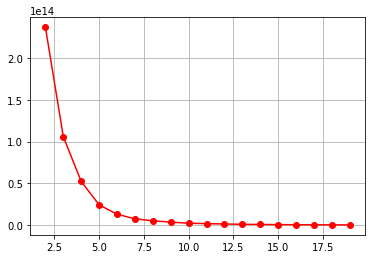

In [27]:
elbow_method(df)

The above diagram suggests to use 6 as a number of clusters.

## Cluster

This function converts each row of the given df to a cluster label.
We have used k-means with k=6 for clustering.

In [28]:
def discretize(df):
    # remove unneeded columns
    # convert to numpy array
    columns_used = list(set(list(df)) - {"StartTime", "SrcAddr", "Label"})
    num_array = df.as_matrix(columns=columns_used)

    kmeans_labels = KMeans(n_clusters=6).fit(num_array)
    result = pd.DataFrame()
    result["Label"] = df["Label"]
    result["SrcAddr"] = df["SrcAddr"]
    result["ClusterLabel"] = kmeans_labels.labels_

    return result

## Bi-Gram model

The sequential data of an attack host will be used to build a bi-gram sliding window model.

In [29]:
n = 2

def get_sliding_window(sequence):
    i = 0
    result = []
    while i <= len(sequence) - n:
        result.append(tuple(sequence[i:i+n]))
        i += 1
    return result


def get_ngram_model(sequence):
    records = get_sliding_window(sequence)
    unique_records = set(records)
    result = {}
    for record in unique_records:
        result[record] = records.count(record)/float(len(records))
    return result


def get_probability(ngram_model, sequence):
    records = get_sliding_window(sequence)
    p = 0.0
    for record in records:
        if record in ngram_model.keys():
            p += ngram_model[record]
    normalized_p = p/len(records)
    return normalized_p

def classify(ngram_model, sequence, threshold):
    p = get_probability(ngram_model, sequence)
    if p > threshold:
        return 1
    else:
        return 0

## Tune threshold

The test is done as following:

A Bi-gram model is learned for each infected host.

Subsequently, this model is used to classify other infected and not infected hosts.

In [30]:
# This function splits the df in groups of infected and uninfected hosts
def split_data(df):
    def groupby_host(df):
        df_groupby_by_src = df.groupby("SrcAddr")
        result = []
        for src in df_groupby_by_src.groups.keys():
            df_groupby_by_src.get_group(src)
            result.append(df_groupby_by_src.get_group(src)["ClusterLabel"].values.tolist())
        return result

    df_group_by_label = df.groupby("Label")
    result = {}
    result[0] = groupby_host(df_group_by_label.get_group(0))
    result[1] = groupby_host(df_group_by_label.get_group(1))
    return result

In [31]:
def plot_hist(data, title):
    plt.hist(data, bins="auto")
    plt.title(title)
    plt.ylabel('Probability')
    plt.show()

def plot_probabilities(df):
    new_df = discretize(df)
    split = split_data(new_df)

    num_attack_hosts = len(split[1])
    num_normal_hosts = len(split[0])

    attact_p = []
    normal_p = []
    for i in range(num_attack_hosts):
        ngram_model = get_ngram_model(split[1][i])
        for j in range(i) + range(i+1, num_attack_hosts):
            attact_p.append(get_probability(ngram_model, split[1][j]))

        for k in range(num_normal_hosts):
            normal_p.append(get_probability(ngram_model, split[0][k]))

    plot_hist(attact_p, "Attack distribution")
    plot_hist(normal_p, "Normal distribution")

Let's view the distribution of the probabilities for infected and not infected host. By doing this we can set a good threshold for classification.

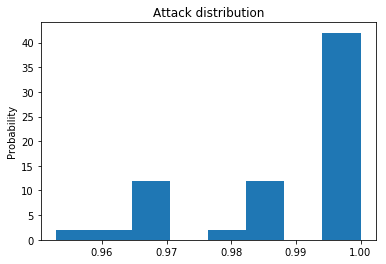

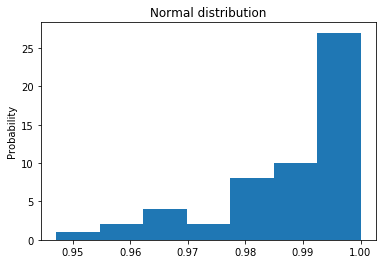

In [32]:
plot_probabilities(df)

It looks like 0.99 is a good threshold (>0.99: attack). If we put the threshold lower almost all of the normal hosts will be classified as attack. But if we put the threshold higher than 0.99 then all of the attack hosts will classified as normal. Hence 0.99 is a good tradeoff between FP and FN.

## Evaluate

In [35]:
def evaluate(threshold, df):
    new_df = discretize(df)
    split = split_data(new_df)
    
    num_attack_hosts = len(split[1])
    num_normal_hosts = len(split[0])

    predicted_labels = []
    real_labels = []
    for i in range(num_attack_hosts):
        ngram_model = get_ngram_model(split[1][i])
        for j in range(i) + range(i + 1, num_attack_hosts):
            real_labels.append(1)
            predicted_labels.append(classify(ngram_model, split[1][j], threshold))

        for k in range(num_normal_hosts):
            real_labels.append(0)
            predicted_labels.append(classify(ngram_model, split[0][k], threshold))
    return confusion_matrix(real_labels, predicted_labels)

Let's see how the classifier with 0.99 threshold performs.

For that we present the confusion matrix.

In [37]:
print "The "
evaluate(0.99, df)

array([[27, 27],
       [30, 42]])

It has an accuracy of 54.8 %. As mentioned in the lectures, the classification in this context is rather hard. Thus, we believe that our results are sufficient.